### t-SNE + K-means + VAE
1.	t-SNE로 데이터 변환
	- t-SNE를 사용하여 고차원 데이터를 저차원으로 변환하고, 클러스터를 분석합니다.
2.	클러스터 레이블 생성
	- t-SNE 결과에서 K-means와 같은 클러스터링 알고리즘을 사용하여 각 데이터 포인트에 클러스터 레이블을 할당합니다.
3.	클러스터 레이블을 VAE 입력에 추가
	- 각 데이터 포인트의 클러스터 레이블을 VAE의 입력 특성으로 추가하여 모델이 클러스터 정보를 학습하도록 합니다.
4.	VAE 모델 훈련:
	- 클러스터 레이블을 포함한 데이터를 사용하여 VAE를 훈련시킵니다.
5.	이상 탐지:
	- 훈련된 VAE를 사용하여 새로운 데이터에 대해 이상 탐지를 수행합니다.

In [1]:
# 필요한 라이브러리 임포트
import numpy as np
import pandas as pd
import random
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.graph_objs as go

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# 난수 생성 고정
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# 데이터 경로 설정
DATA_PATH = Path("./data")
train_data = pd.read_csv(DATA_PATH / "train.csv")
test_data = pd.read_csv(DATA_PATH / "test.csv")

# 필요 피처 선택
non_numeric_cols = ["faultNumber", "simulationRun", "sample"]
use_cols = train_data.columns.difference(non_numeric_cols)

X_train = train_data[use_cols]
X_test = test_data[use_cols]

# 데이터 스케일러 인스턴스 생성(데이터 표준화)
scaler = MinMaxScaler()
# 학습 데이터셋에 대해 fit과 transform 수행: train 기준 정보 계산 및 데이터 변환
X_train_scaled = scaler.fit_transform(X_train) 
# 테스트 데이터셋에 대해서는 transform만 수행: 학습 데이터셋의 기준 정보를 사용하여 데이터 변환
X_test_scaled = scaler.transform(X_test)

# PyTorch Tensor로 변환 
X_train_tensor = torch.FloatTensor(X_train_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)

⚠️ 시간 소요! (85분 소요)

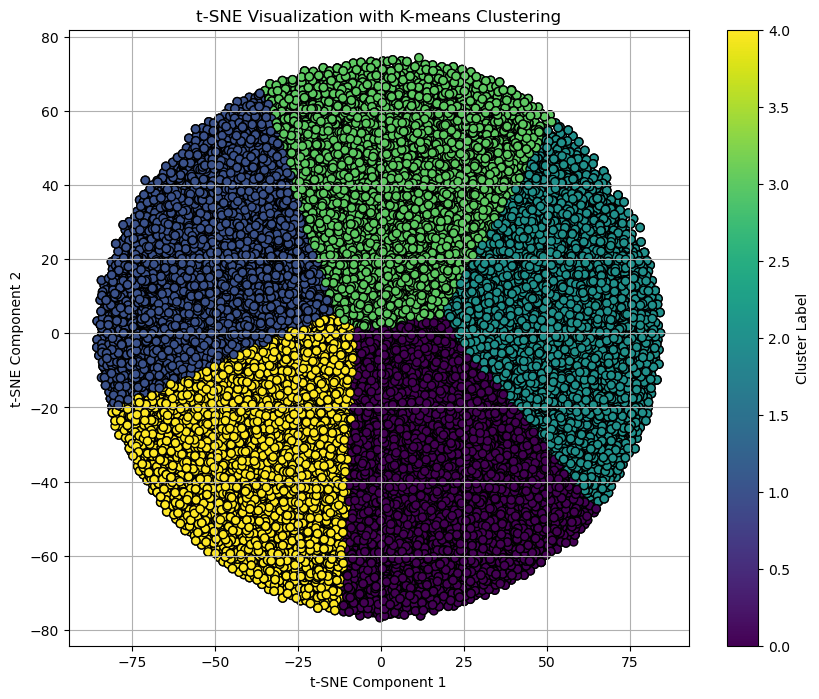

In [3]:
# t-SNE 적용
X_train_numpy = X_train_tensor.cpu().numpy()  # NumPy 배열로 변환 (GPU에 있을 경우 CPU로 이동)
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train_numpy)

# K-means 클러스터링
kmeans = KMeans(n_clusters=5, random_state=42)  # 클러스터 수 설정
labels = kmeans.fit_predict(X_tsne)

# 클러스터 레이블을 원본 데이터에 추가
X_train_with_labels = np.hstack((X_train_numpy, labels.reshape(-1, 1)))

# 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k')
plt.title("t-SNE Visualization with K-means Clustering")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(scatter, label='Cluster Label')
plt.grid()
plt.show()

In [4]:
print(X_train_with_labels.shape)
df = pd.DataFrame(X_train_with_labels)
df.to_csv("./X_train_with_labels.csv")

(250000, 53)


In [11]:
# VAE 모델 정의 (클러스터 레이블을 추가한 입력 크기)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F  # 이 줄을 추가

class VAE(nn.Module):
    def __init__(self, input_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc21 = nn.Linear(128, 20)  # 평균
        self.fc22 = nn.Linear(128, 20)  # 로그 분산
        self.fc3 = nn.Linear(20, 128)
        self.fc4 = nn.Linear(128, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))  # Sigmoid 활성화 함수 추가

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# 손실 함수 정의
def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.BCELoss(reduction='sum')(recon_x, x)  # 재구성 손실
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # KL 발산
    return recon_loss + kld_loss

# 데이터 준비
device = torch.device('cpu')  # CPU 사용
df = pd.read_csv("./X_train_with_labels.csv")
X_train_with_labels_numpy = df.values

# 데이터 정규화: 최소-최대 정규화 (Min-Max Scaling)
X_min = X_train_with_labels_numpy.min(axis=0)
X_max = X_train_with_labels_numpy.max(axis=0)
X_train_with_labels_normalized = (X_train_with_labels_numpy - X_min) / (X_max - X_min)

X_train_with_labels_tensor = torch.FloatTensor(X_train_with_labels_normalized).to(device)

# TensorDataset 및 DataLoader로 데이터 배치 처리
dataset = TensorDataset(X_train_with_labels_tensor)  # 텐서 데이터셋 생성
batch_size = 64  # 원하는 배치 크기로 설정
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 모델, 손실 함수 및 옵티마이저 설정
model = VAE(input_dim=X_train_with_labels_tensor.shape[1]).to(device)  # 클러스터 레이블 포함 및 GPU로 이동
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [12]:
# 학습 과정
num_epochs = 10
model.train()

for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, batch_data in enumerate(train_loader):
        # batch_data가 리스트라면 첫 번째 항목이 실제 텐서 데이터임
        if isinstance(batch_data, list):
            batch_data = batch_data[0]
        
        data = batch_data.to(device)  # 데이터를 GPU로 이동
        optimizer.zero_grad()
        
        # VAE를 통한 이상 탐지 모델 학습
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset):.4f}')

print("Training finished.")

Epoch 1, Loss: 37.4033
Epoch 2, Loss: 37.3937
Epoch 3, Loss: 37.3934
Epoch 4, Loss: 37.3933
Epoch 5, Loss: 37.3933
Epoch 6, Loss: 37.3933
Epoch 7, Loss: 37.3932
Epoch 8, Loss: 37.3933
Epoch 9, Loss: 37.3933
Epoch 10, Loss: 37.3932
Training finished.


In [13]:
# 이상 탐지를 위한 임계값 설정 및 이상 여부 판단
def detect_anomaly(data, model, threshold):
    model.eval()
    with torch.no_grad():
        recon, _, _ = model(data.to(device))
        recon_error = torch.mean((recon - data.to(device)) ** 2, dim=1)  # MSE 계산
        return recon_error > threshold  # 재구성 오차가 임계값을 넘는 경우 이상으로 판단

# 정상 데이터에서 추정한 임계값을 설정
normal_data = X_train_tensor
recon_errors = []
for data in normal_data:
    recon, _, _ = model(data.unsqueeze(0).to(device))
    error = torch.mean((recon - data.unsqueeze(0).to(device)) ** 2).item()
    recon_errors.append(error)

# 임계값을 정상 데이터의 평균 오차 + 3*표준편차로 설정
threshold = torch.tensor(recon_errors).mean() + 3 * torch.tensor(recon_errors).std()

# 새로운 데이터로 이상 탐지 수행
test_data = X_test_tensor.to(device) # 테스트 데이터 (정상 또는 이상)
is_anomaly = detect_anomaly(test_data, model, threshold)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x52 and 54x128)

In [5]:
# is_anomaly를 0과 1로 변환
is_anomaly_numeric = is_anomaly.int()  # True는 1, False는 0으로 변환

# NumPy 배열로 변환
is_anomaly_array = is_anomaly_numeric.cpu().numpy()  # CPU로 이동 후 NumPy로 변환

# DataFrame 생성
df = pd.DataFrame(is_anomaly_array, columns=['faultNumber'])

In [ ]:
df.value_counts()

In [25]:
from datetime import datetime

# CSV 파일로 저장
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"output_vae_{current_time}.csv"
df.to_csv(filename)

In [ ]:
print(threshold)